### Blog post on low wage work and employment rates

January 23, 2019

Brian Dew, @bd_econ

In [ ]:
# # Get names of CBSAs
# url = 'https://www.uspto.gov/web/offices/ac/ido/oeip/taf/cls_cbsa/cbsa_countyassoc.htm'
# cbsa_list = pd.read_html(url)[0]
# cbsas = cbsa_list.set_index('CBSA Code')['CBSA Title'].to_dict()
# # Fill in the gaps:
# d = {14010: 'Bloomington, IL',
#      15680: 'California-Lexington Park, MD',
#      16060: 'Carbondale-Marion, IL',
#      16540: 'Chambersburg-Waynesboro, PA',
#      19300: 'Daphne-Fairhope-Foley, AL',
#      20700: 'East Stroudsburg, PA',
#      25940: 'Hilton Head Island-Bluffton-Beaufort, SC',
#      27980: 'Kahului-Wailuku-Lahaina, HI',
#      29200: 'Lafayette-West Lafayette, IN',
#      31080: 'Los Angeles-Long Beach-Anaheim, CA',
#      42200: 'Santa Maria-Santa Barbara, CA',
#      46520: 'Urban Honolulu, HI',
#      48060: 'Watertown-Fort Drum, NY'}

# cbsa_dict = {**cbsas, **d}

# # Save CBSA names 
# pd.Series(cbsa_dict).to_csv('CBSA_Names.csv')

In [15]:
cbsa_dict = pd.read_csv('CBSA_Names.csv',index_col=0)['0'].to_dict()

In [5]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir('/home/brian/Documents/CPS/data/clean/')

# Define various functions to apply to grouped data
def epop(group):
    """Calculate epop for group"""
    d = np.where(group['LFS'] == 'Employed', 1, 0)
    w = group['BASICWGT']
    return (d * w).sum() / w.sum() * 100.0

def p10wage(group):
    """Return BLS-styled binned first decile wage"""
    wage_var = 'HRWAGE'
    weight = 'PWORWGT'
    group = group.query('PWORWGT > 0 and HRWAGE > 0 and WORKFT == 1')
    bin_size = 0.5 #($0.50)
    bins = list(np.arange(0.25, 300, bin_size))
    bin_cut = lambda x: pd.cut(x[wage_var], bins, include_lowest=True)
    cum_sum = lambda x: x[weight].cumsum()
    dft = (group.sort_values(wage_var)
                .assign(WAGE_RANGE = bin_cut, CS = cum_sum))
    p10_point = dft[weight].sum() * 0.1
    p10_bin = (dft.iloc[(dft['CS'] - p10_point).abs().argsort()[:1]]
                  .WAGE_RANGE.values[0])
    wage_bins = list(dft['WAGE_RANGE'].unique())
    p10_loc = wage_bins.index(p10_bin)
    bin_below = dft[dft['WAGE_RANGE'] == wage_bins[p10_loc-1]].iloc[-1].CS
    bin_above = dft[dft['WAGE_RANGE'] == wage_bins[p10_loc]].iloc[-1].CS
    p10_value = ((((p10_point - bin_below) / 
                   (bin_above - bin_below)) * bin_size) + p10_bin.left)
    return p10_value

def unionmem(group):
    group = group.query('UNIONMEM in [0, 1]')
    member = group[group['UNIONMEM']==1]
    return member['PWORWGT'].sum() / group['PWORWGT'].sum() * 100.0

def unemp(group):
    group = group.query('LFS != "NILF"')
    unemp = group[group['LFS'] == 'Unemployed']
    return unemp['BASICWGT'].sum() / group['BASICWGT'].sum() * 100.0

def groupsize(group):
    group = group.query('PWORWGT > 0 and HRWAGE > 0 and WORKFT == 1')
    return len(group)

In [3]:
# Retrieve latest two years of CPS data
keep_cols = ['YEAR', 'MONTH', 'AGE', 'BASICWGT', 'LFS', 'UNIONMEM',
             'WORKFT', 'PWORWGT', 'HRWAGE', 'CBSA']
keep_rows1 = '18 <= AGE <= 64'
df2 = (pd.read_feather(f'cps2023.ft').filter(keep_cols).query(keep_rows1+' and MONTH > 4'))
df3 = (pd.read_feather(f'cps2024.ft').filter(keep_cols).query(keep_rows1))
df4 = (pd.read_feather(f'cps2025.ft').filter(keep_cols).query(keep_rows1))

df = pd.concat([df2, df3, df4])

In [16]:
# Apply calculations and save results
data = pd.DataFrame()
data['Count'] = df.groupby('CBSA').apply(groupsize)
data = data[data['Count'] > 500]
data['EPOP'] = df.groupby('CBSA').apply(epop)
data['P10wage'] = df.groupby('CBSA').apply(p10wage)
data['Union'] = df.groupby('CBSA').apply(unionmem)
data['Unemp'] = df.groupby('CBSA').apply(unemp)
data['Name'] = data.index.map(cbsa_dict)
data.to_csv('CBSA_2YR_Indicators_.csv')

/tmp/ipykernel_316068/2938645264.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data['Count'] = df.groupby('CBSA').apply(groupsize)
/tmp/ipykernel_316068/2938645264.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['Count'] = df.groupby('CBSA').apply(groupsize)
/tmp/ipykernel_316068/2938645264.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the futur

/tmp/ipykernel_300468/1288381007.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  p10_bin = (dft.iloc[(dft['CS'] - p10_point).abs().argsort()[:1]]
/tmp/ipykernel_300468/1288381007.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  p10_bin = (dft.iloc[(dft['CS'] - p10_point).abs().argsort()[:1]]
/tmp/ipykernel_300468/1288381007.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-ba

/tmp/ipykernel_300468/1288381007.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  p10_bin = (dft.iloc[(dft['CS'] - p10_point).abs().argsort()[:1]]
/tmp/ipykernel_300468/1288381007.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  p10_bin = (dft.iloc[(dft['CS'] - p10_point).abs().argsort()[:1]]
/tmp/ipykernel_300468/1288381007.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-ba

/tmp/ipykernel_300468/1288381007.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  p10_bin = (dft.iloc[(dft['CS'] - p10_point).abs().argsort()[:1]]
/tmp/ipykernel_300468/1288381007.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  p10_bin = (dft.iloc[(dft['CS'] - p10_point).abs().argsort()[:1]]
/tmp/ipykernel_300468/1288381007.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-ba

/tmp/ipykernel_300468/1288381007.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  p10_bin = (dft.iloc[(dft['CS'] - p10_point).abs().argsort()[:1]]
/tmp/ipykernel_300468/1288381007.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  p10_bin = (dft.iloc[(dft['CS'] - p10_point).abs().argsort()[:1]]
/tmp/ipykernel_300468/1288381007.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-ba

/tmp/ipykernel_300468/1288381007.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  p10_bin = (dft.iloc[(dft['CS'] - p10_point).abs().argsort()[:1]]
/tmp/ipykernel_300468/1288381007.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  p10_bin = (dft.iloc[(dft['CS'] - p10_point).abs().argsort()[:1]]
/tmp/ipykernel_300468/1288381007.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-ba

/tmp/ipykernel_300468/1288381007.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  p10_bin = (dft.iloc[(dft['CS'] - p10_point).abs().argsort()[:1]]
/tmp/ipykernel_300468/1288381007.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  p10_bin = (dft.iloc[(dft['CS'] - p10_point).abs().argsort()[:1]]
/tmp/ipykernel_300468/1288381007.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-ba

/tmp/ipykernel_300468/1288381007.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  p10_bin = (dft.iloc[(dft['CS'] - p10_point).abs().argsort()[:1]]
/tmp/ipykernel_300468/1288381007.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  p10_bin = (dft.iloc[(dft['CS'] - p10_point).abs().argsort()[:1]]
/tmp/ipykernel_300468/1288381007.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-ba

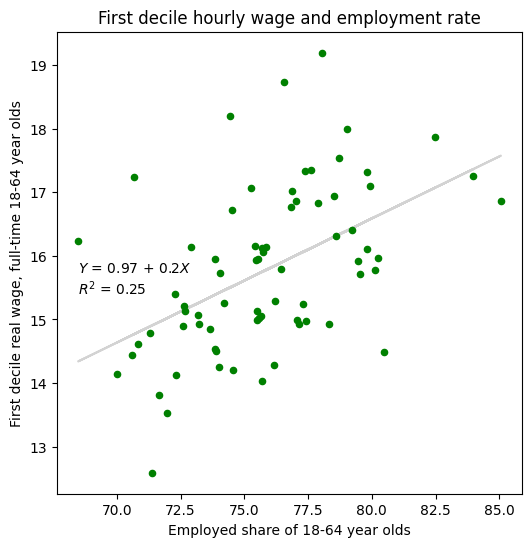

In [21]:
# Scatter plot of epop and first decile wage
y = data['P10wage']
x = data['EPOP']

r2 = np.corrcoef(x, y)[0, 1]**2
fit = np.polyfit(x, y, 1)

data.plot(kind='scatter', x='EPOP', y='P10wage', 
          zorder=2, color='green', figsize=(6, 6))
plt.plot(x, np.poly1d(fit)(x), color='lightgray', zorder=1)
text = f'$Y$ = {round(fit[1], 2)} + {round(fit[0], 2)}$X$\n$R^2$ = {round(r2, 2)}'
plt.text(x.min(), 15.4, text)
plt.title('First decile hourly wage and employment rate')
plt.xlabel('Employed share of 18-64 year olds')
plt.ylabel('First decile real wage, full-time 18-64 year olds');
#plt.savefig('CBSA_p10wage_epop.png')

In [18]:
data.sort_values('EPOP')

,Count,EPOP,P10wage,Union,Unemp,Name
CBSA,,,,,,
40140,1773,68.482896,16.229667,17.735615,4.951083,"Riverside-San Bernardino-Ontario, CA"
35380,797,70.007949,14.148028,4.968736,4.269284,"New Orleans-Metairie-Kenner, LA"
32820,737,70.602364,14.435334,6.990001,4.755765,"Memphis, TN-MS-AR"
40900,766,70.675008,17.248557,19.461864,4.424541,"Sacramento--Arden-Arcade--Roseville, CA"
30780,848,70.823910,14.617530,3.613462,3.435767,"Little Rock-North Little Rock-Conway, AR"
...,...,...,...,...,...,...
36540,1221,80.250986,15.960393,6.170100,2.747674,"Omaha-Council Bluffs, NE-IA"
48620,593,80.467498,14.484930,8.137664,2.979961,"Wichita, KS"
33460,1690,82.482892,17.877173,13.276248,3.124594,"Minneapolis-St. Paul-Bloomington, MN-WI"
